### Metrics
- for each dataset, load x and z, then compute silhouette score and trustworthiness
- save metrics to a pandas dataframe

In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_score

In [3]:
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [5]:
output_dir = MODEL_DIR/'projections' 

In [6]:
#from https://gist.github.com/AlexandreAbraham/5544803
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import distance_metrics
from sklearn.metrics.pairwise import pairwise_distances
from joblib import Parallel, delayed
from itertools import combinations


def silhouette_score_block(X, labels, metric='euclidean', sample_size=None,
                           random_state=None, n_jobs=1, **kwds):
    """Compute the mean Silhouette Coefficient of all samples.
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (a) and the mean nearest-cluster distance (b) for each sample.
    The Silhouette Coefficient for a sample is ``(b - a) / max(a, b)``.
    To clarrify, b is the distance between a sample and the nearest cluster
    that b is not a part of.
    This function returns the mean Silhoeutte Coefficient over all samples.
    To obtain the values for each sample, use silhouette_samples
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters. Negative values generally indicate that a sample has
    been assigned to the wrong cluster, as a different cluster is more similar.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
             label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    sample_size : int or None
        The size of the sample to use when computing the Silhouette
        Coefficient. If sample_size is None, no sampling is used.
    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    silhouette : float
        Mean Silhouette Coefficient for all samples.
    References
    ----------
    Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the
        Interpretation and Validation of Cluster Analysis". Computational
        and Applied Mathematics 20: 53-65. doi:10.1016/0377-0427(87)90125-7.
    http://en.wikipedia.org/wiki/Silhouette_(clustering)
    """
    if sample_size is not None:
        random_state = check_random_state(random_state)
        indices = random_state.permutation(X.shape[0])[:sample_size]
        if metric == "precomputed":
            raise ValueError('Distance matrix cannot be precomputed')
        else:
            X, labels = X[indices], labels[indices]
    sil_samp = silhouette_samples_block(
        X, labels, metric=metric, n_jobs=n_jobs, **kwds)
    return np.mean(sil_samp), sil_samp


def silhouette_samples_block(X, labels, metric='euclidean', n_jobs=1, **kwds):
    """Compute the Silhouette Coefficient for each sample.
    The Silhoeutte Coefficient is a measure of how well samples are clustered
    with samples that are similar to themselves. Clustering models with a high
    Silhouette Coefficient are said to be dense, where samples in the same
    cluster are similar to each other, and well separated, where samples in
    different clusters are not very similar to each other.
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (a) and the mean nearest-cluster distance (b) for each sample.
    The Silhouette Coefficient for a sample is ``(b - a) / max(a, b)``.
    This function returns the Silhoeutte Coefficient for each sample.
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
             label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    silhouette : array, shape = [n_samples]
        Silhouette Coefficient for each samples.
    References
    ----------
    Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the
        Interpretation and Validation of Cluster Analysis". Computational
        and Applied Mathematics 20: 53-65. doi:10.1016/0377-0427(87)90125-7.
    http://en.wikipedia.org/wiki/Silhouette_(clustering)
    """
    A = _intra_cluster_distances_block(X, labels, metric, n_jobs=n_jobs,
                                       **kwds)
    B = _nearest_cluster_distance_block(X, labels, metric, n_jobs=n_jobs,
                                        **kwds)
    sil_samples = (B - A) / np.maximum(A, B)
    # nan values are for clusters of size 1, and should be 0
    return np.nan_to_num(sil_samples)


def _intra_cluster_distances_block_(subX, metric, **kwds):
    distances = pairwise_distances(subX, metric=metric, **kwds)
    return distances.sum(axis=1) / (distances.shape[0] - 1)


def _intra_cluster_distances_block(X, labels, metric, n_jobs=1, **kwds):
    """Calculate the mean intra-cluster distance for sample i.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
        label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    a : array [n_samples_a]
        Mean intra-cluster distance
    """
    intra_dist = np.zeros(labels.size, dtype=float)
    values = Parallel(n_jobs=n_jobs)(
            delayed(_intra_cluster_distances_block_)
                (X[np.where(labels == label)[0]], metric, **kwds)
                for label in np.unique(labels))
    for label, values_ in zip(np.unique(labels), values):
        intra_dist[np.where(labels == label)[0]] = values_
    return intra_dist


def _nearest_cluster_distance_block_(subX_a, subX_b, metric, **kwds):
    dist = pairwise_distances(subX_a, subX_b, metric=metric, **kwds)
    dist_a = dist.mean(axis=1)
    dist_b = dist.mean(axis=0)
    return dist_a, dist_b


def _nearest_cluster_distance_block(X, labels, metric, n_jobs=1, **kwds):
    """Calculate the mean nearest-cluster distance for sample i.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
        label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    X : array [n_samples_a, n_features]
        Feature array.
    Returns
    -------
    b : float
        Mean nearest-cluster distance for sample i
    """
    inter_dist = np.empty(labels.size, dtype=float)
    inter_dist.fill(np.inf)
    # Compute cluster distance between pairs of clusters
    unique_labels = np.unique(labels)

    values = Parallel(n_jobs=n_jobs)(
            delayed(_nearest_cluster_distance_block_)(
                X[np.where(labels == label_a)[0]],
                X[np.where(labels == label_b)[0]],
                metric, **kwds)
                for label_a, label_b in combinations(unique_labels, 2))

    for (label_a, label_b), (values_a, values_b) in \
            zip(combinations(unique_labels, 2), values):

            indices_a = np.where(labels == label_a)[0]
            inter_dist[indices_a] = np.minimum(values_a, inter_dist[indices_a])
            del indices_a
            indices_b = np.where(labels == label_b)[0]
            inter_dist[indices_b] = np.minimum(values_b, inter_dist[indices_b])
            del indices_b
    return inter_dist

In [7]:
metrics_df = pd.DataFrame(columns = ['dataset', 'class_', 'dim', 'trustworthiness', 'silhouette_score', 'silhouette_samples'])

### MNIST

##### load dataset

In [8]:
from tensorflow.keras.datasets import mnist

# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


#### load projections

In [9]:
dataset = 'mnist'

In [10]:
classes = ['umap-learn', 'network', 'autoencoder', 'PCA', 'TSNE']

In [11]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / class_)
    z = np.load(output_dir / dataset / class_ / 'z_test.npy')
    projection_df.loc[len(projection_df)] = [dataset, class_, z, Y_test]
projection_df['dim'] = 2

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/umap-learn
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/network
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/autoencoder
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/PCA
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/TSNE


In [12]:
projection_df_64 = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / '64' / class_ / 'z_test.npy')
    try:
        z = np.load(output_dir / dataset / '64' / class_ / 'z_test.npy')
        projection_df_64.loc[len(projection_df_64)] = [dataset, class_, z, Y_test]
    except FileNotFoundError as e:
        print(e)
projection_df_64['dim'] = 64

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/umap-learn/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/network/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/autoencoder/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/PCA/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/TSNE/z_test.npy
[Errno 2] No such file or directory: '/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/mnist/64/TSNE/z_test.npy'


In [13]:
projection_df_64

,dataset,class_,train_z,train_label,dim
0,mnist,umap-learn,"[[10.357074, 1.5838902, 7.035351, 5.7068515, 4...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",64
1,mnist,network,"[[0.4765154, -1.242, -1.4237565, -0.67418647, ...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",64
2,mnist,autoencoder,"[[-0.6130227, 0.12474405, 0.018241605, 0.07817...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",64
3,mnist,PCA,"[[-1.2580044, 2.9119534, -0.10601278, -1.14694...","[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, ...",64


##### compute silhouette score and trustworthiness

In [14]:
for idx, row in tqdm(pd.concat([projection_df, projection_df_64]).iterrows(), total = len(projection_df)+ len(projection_df_64)):
    ss, sil_samp = silhouette_score_block(row.train_z, row.train_label, n_jobs = -1)
    tw = trustworthiness(X_test_flat[:10000], row.train_z[:10000])
    metrics_df.loc[len(metrics_df)] = [dataset, row.class_, row.dim, tw, ss, sil_samp]

### FMNIST

##### load dataset

In [15]:
from tensorflow.keras.datasets import fashion_mnist

# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


#### load projections

In [16]:
dataset = 'fmnist'

In [17]:
classes = ['umap-learn', 'network', 'autoencoder', 'PCA', 'TSNE']

In [18]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / class_)
    z = np.load(output_dir / dataset / class_ / 'z_test.npy')
    projection_df.loc[len(projection_df)] = [dataset, class_, z, Y_test]
projection_df['dim'] = 2

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/umap-learn
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/network
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/autoencoder
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/PCA
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/TSNE


In [19]:
projection_df_64 = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / '64' / class_ / 'z_test.npy')
    try:
        z = np.load(output_dir / dataset / '64' / class_ / 'z_test.npy')
        projection_df_64.loc[len(projection_df_64)] = [dataset, class_, z, Y_test]
    except FileNotFoundError as e:
        print(e)
projection_df_64['dim'] = 64

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/64/umap-learn/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/64/network/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/64/autoencoder/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/64/PCA/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/64/TSNE/z_test.npy
[Errno 2] No such file or directory: '/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/64/TSNE/z_test.npy'


##### compute silhouette score and trustworthiness

In [20]:
for idx, row in tqdm(pd.concat([projection_df, projection_df_64]).iterrows(), total = len(projection_df)+ len(projection_df_64)):
    ss, sil_samp = silhouette_score_block(row.train_z, row.train_label, n_jobs = -1)
    tw = trustworthiness(X_test_flat[:10000], row.train_z[:10000])
    metrics_df.loc[len(metrics_df)] = [dataset, row.class_, row.dim, tw, ss, sil_samp]

### CIFAR10

##### load dataset

In [21]:
from tensorflow.keras.datasets import cifar10

# load dataset
(train_images, Y_train), (test_images, Y_test) = cifar10.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:].flatten()
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid].flatten()
Y_test = Y_test.flatten()
X_test_flat = X_test

print(len(X_train), len(X_valid), len(X_test))

40000 10000 10000


#### load projections

In [22]:
dataset = 'cifar10'

In [23]:
classes = ['umap-learn', 'network', 'autoencoder', 'PCA', 'TSNE']

In [24]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / class_)
    z = np.load(output_dir / dataset / class_ / 'z_test.npy')
    projection_df.loc[len(projection_df)] = [dataset, class_, z, Y_test]
projection_df['dim'] = 2

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/umap-learn
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/network
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/autoencoder
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/PCA
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/TSNE


In [25]:
projection_df_64 = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / '64' / class_ / 'z_test.npy')
    try:
        z = np.load(output_dir / dataset / '64' / class_ / 'z_test.npy')
        projection_df_64.loc[len(projection_df_64)] = [dataset, class_, z, Y_test]
    except FileNotFoundError as e:
        print(e)
projection_df_64['dim'] = 64

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/64/umap-learn/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/64/network/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/64/autoencoder/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/64/PCA/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/64/TSNE/z_test.npy
[Errno 2] No such file or directory: '/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cifar10/64/TSNE/z_test.npy'


In [26]:
projection_df_64

,dataset,class_,train_z,train_label,dim
0,cifar10,umap-learn,"[[6.9873776, 9.125104, 7.1634693, 6.643967, 5....","[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, ...",64
1,cifar10,network,"[[-0.029608527, 0.12517297, -0.21703288, 0.036...","[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, ...",64
2,cifar10,autoencoder,"[[0.082228325, -0.002842024, -0.08078372, 0.02...","[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, ...",64
3,cifar10,PCA,"[[-3.4676628, 0.91849434, 1.2494233, 3.553762,...","[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, ...",64


##### compute silhouette score and trustworthiness

In [27]:
for idx, row in tqdm(pd.concat([projection_df, projection_df_64]).iterrows(), total = len(projection_df)+ len(projection_df_64)):
    ss, sil_samp = silhouette_score_block(row.train_z, row.train_label, n_jobs = -1)
    tw = trustworthiness(X_test_flat[:10000], row.train_z[:10000])
    metrics_df.loc[len(metrics_df)] = [dataset, row.class_, row.dim, tw, ss, sil_samp]

### Macosko

##### load dataset

In [28]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#dataset_address = 'http://file.biolab.si/opentsne/macosko_2015.pkl.gz'
# https://opentsne.readthedocs.io/en/latest/examples/01_simple_usage/01_simple_usage.html
# also see https://github.com/berenslab/rna-seq-tsne/blob/master/umi-datasets.ipynb

import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

print("Data set contains %d samples with %d features" % x.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=.1, random_state=42)

np.shape(X_train)

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

X_train_flat = X_train
X_test_flat = X_test

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()

Data set contains 44808 samples with 50 features


In [29]:
dataset = 'macosko2015'

In [30]:
classes = ['umap-learn', 'network', 'autoencoder', 'PCA', 'TSNE']

In [31]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / class_)
    z = np.load(output_dir / dataset / class_ / 'z_test.npy')
    projection_df.loc[len(projection_df)] = [dataset, class_, z, Y_test]
projection_df['dim'] = 2

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/umap-learn
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/network
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/autoencoder
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/PCA
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/TSNE


In [32]:
import matplotlib.pyplot as plt

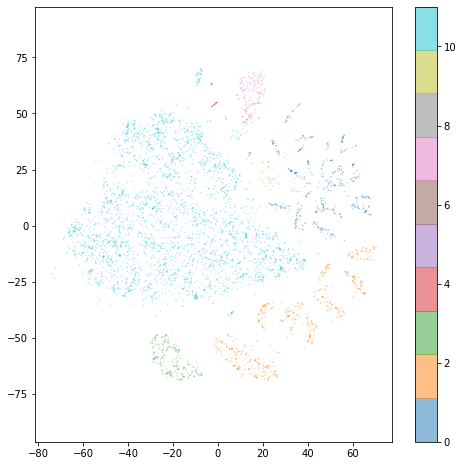

In [33]:
z = projection_df[projection_df.class_== 'TSNE'].train_z.values[0]
y = projection_df.train_label.values[0]
y = enc.fit_transform([[i] for i in y]).flatten()
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=y,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
plt.colorbar(sc, ax=ax);

In [34]:
from sklearn.metrics import silhouette_score

In [35]:
silhouette_score(z, y)

0.04540748992057796

In [36]:
ss, sil_samp = silhouette_score_block(z, y.astype('int'), n_jobs = -1)
ss

0.04540748992057795

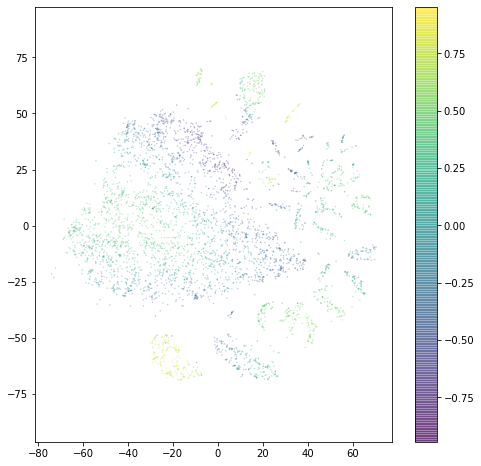

In [37]:
z = projection_df[projection_df.class_== 'TSNE'].train_z.values[0]
y = projection_df.train_label.values[0]
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=sil_samp,
    cmap="viridis",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
plt.colorbar(sc, ax=ax);

(array([  60.,  267.,  434.,  620.,  583.,  646., 1028.,  543.,  105.,
         195.]),
 array([-0.94406126, -0.75434224, -0.56462323, -0.37490421, -0.1851852 ,
         0.00453382,  0.19425284,  0.38397185,  0.57369087,  0.76340988,
         0.9531289 ]),
 <a list of 10 Patch objects>)

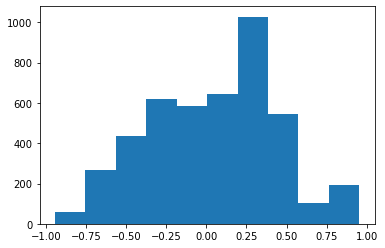

In [38]:
plt.hist(sil_samp)

In [39]:
projection_df_64 = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / '64' / class_ / 'z_test.npy')
    try:
        z = np.load(output_dir / dataset / '64' / class_ / 'z_test.npy')
        projection_df_64.loc[len(projection_df_64)] = [dataset, class_, z, y]
    except FileNotFoundError as e:
        print(e)
projection_df_64['dim'] = 64

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/umap-learn/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/network/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/autoencoder/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/PCA/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/TSNE/z_test.npy
[Errno 2] No such file or directory: '/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/TSNE/z_test.npy'


In [40]:
projection_df_64

,dataset,class_,train_z,train_label,dim
0,macosko2015,umap-learn,"[[1.0537016, 8.398526, 10.593911, 0.35060787, ...","[Rods, Amacrine cells, Rods, Rods, Amacrine ce...",64
1,macosko2015,network,"[[1.4117787, -0.57711494, -1.275607, 0.9532537...","[Rods, Amacrine cells, Rods, Rods, Amacrine ce...",64
2,macosko2015,autoencoder,"[[-1.0849965, 6.8297834, -1.2966242, 3.6598475...","[Rods, Amacrine cells, Rods, Rods, Amacrine ce...",64
3,macosko2015,PCA,"[[-6.048407231019987, 0.8438246575800042, 1.50...","[Rods, Amacrine cells, Rods, Rods, Amacrine ce...",64


##### compute silhouette score and trustworthiness

In [41]:
for idx, row in tqdm(pd.concat([projection_df, projection_df_64]).iterrows(), total = len(projection_df)+ len(projection_df_64)):
    ss, sil_samp = silhouette_score_block(row.train_z, row.train_label, n_jobs = -1)
    tw = trustworthiness(X_test_flat[:10000], row.train_z[:10000])
    metrics_df.loc[len(metrics_df)] = [dataset, row.class_, row.dim, tw, ss, sil_samp]

### Cassin's

##### load dataset

In [56]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')

top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)

sylllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]


sylllable_df = sylllable_df.reset_index()

specs = np.array(list(sylllable_df.spectrogram.values))
specs.shape

sylllable_df['subset'] = 'train'
sylllable_df.loc[:1000, 'subset'] = 'valid'
sylllable_df.loc[1000:1999, 'subset'] = 'test'


Y_train = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'train']))
Y_valid = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'valid']))
Y_test = np.array(list(sylllable_df.labels.values[sylllable_df.subset == 'test']))

X_train = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(sylllable_df.spectrogram.values[sylllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()

In [57]:
dataset = 'cassins_dtw'

In [58]:
classes = ['umap-learn',  'network', 'autoencoder', 'PCA', 'TSNE']

In [59]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / class_)
    z = np.load(output_dir / dataset / class_ / 'z_test.npy')
    print(z.shape)
    projection_df.loc[len(projection_df)] = [dataset, class_, z, Y_test]
projection_df['dim'] = 2

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/umap-learn
(1000, 2)
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/network
(1000, 2)
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/autoencoder
(1000, 2)
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/PCA
(1000, 2)
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/TSNE
(1000, 2)


In [60]:
projection_df_64 = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label'])
for class_ in classes:
    print(output_dir / dataset / '64' / class_ / 'z_test.npy')
    try:
        z = np.load(output_dir / dataset / '64' / class_ / 'z_test.npy')
        projection_df_64.loc[len(projection_df_64)] = [dataset, class_, z, Y_test]
    except FileNotFoundError as e:
        print(e)
projection_df_64['dim'] = 64

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/umap-learn/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/network/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/autoencoder/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/PCA/z_test.npy
/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/TSNE/z_test.npy
[Errno 2] No such file or directory: '/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/64/TSNE/z_test.npy'


In [61]:
projection_df_64

,dataset,class_,train_z,train_label,dim
0,cassins_dtw,umap-learn,"[[10.0358715, 1.5026189, 1.4839272, 7.6965694,...","[en, ai, aj, en, ai, aj, en, en, ah, ai, en, a...",64
1,cassins_dtw,network,"[[0.00652323, 0.31705543, -0.017104171, -0.094...","[en, ai, aj, en, ai, aj, en, en, ah, ai, en, a...",64
2,cassins_dtw,autoencoder,"[[-0.1901173, -0.06890071, 0.19752231, -0.3321...","[en, ai, aj, en, ai, aj, en, en, ah, ai, en, a...",64
3,cassins_dtw,PCA,"[[-1.3741655, -1.256713, 0.41196084, -1.696582...","[en, ai, aj, en, ai, aj, en, en, ah, ai, en, a...",64


##### compute silhouette score and trustworthiness

In [62]:
len(X_test_flat[:10000]), len(row.train_z)

(1000, 1000)

In [63]:
for idx, row in tqdm(pd.concat([projection_df, projection_df_64]).iterrows(), total = len(projection_df)+ len(projection_df_64)):
    ss, sil_samp = silhouette_score_block(row.train_z, row.train_label, n_jobs = -1)
    tw = trustworthiness(X_test_flat[:10000], row.train_z[:10000])
    metrics_df.loc[len(metrics_df)] = [dataset, row.class_, row.dim, tw, ss, sil_samp]

### Save all

In [64]:
metrics_df.to_pickle(DATA_DIR / 'projection_metrics_test.pickle')

In [65]:
metrics_df[:3]

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,mnist,umap-learn,2,0.957523,0.498622,"[0.6652105430819873, 0.5560565910285055, 0.674..."
1,mnist,network,2,0.940794,0.556763,"[0.6467435975005477, 0.7353703835055341, 0.751..."
2,mnist,autoencoder,2,0.930384,0.469030,"[0.6125063346018064, 0.5963238260826161, 0.657..."


In [66]:
import seaborn as sns

In [67]:
import matplotlib.pyplot as plt

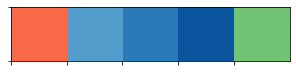

In [82]:
palette = sns.color_palette('Reds', 1) + sns.color_palette('Blues', 6)[3:] + sns.color_palette('Greens', 1)
sns.palplot(palette)

In [83]:
from tfumap.paths import FIGURE_DIR, save_fig

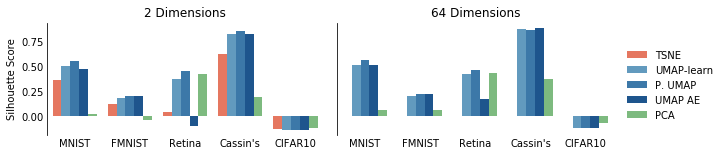

In [88]:
fg = sns.catplot(
    x="dataset",
    y="silhouette_score",
    hue="class_",
    hue_order=["TSNE", "umap-learn",  "network", "autoencoder", "PCA"],
    order = ['mnist', 'fmnist', 'macosko2015', 'cassins_dtw', 'cifar10'],
    col="dim",
    height=2.5, 
    aspect=1.75,
    data=metrics_df,
    kind="bar",
    palette=palette,
    #legend=False
)
(fg.despine(bottom=True)
 .set_xticklabels(['MNIST', 'FMNIST', 'Retina', 'Cassin\'s', 'CIFAR10'])
 .set_axis_labels("", "Silhouette Score")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u'both', which=u'both',length=0)
fg._legend._legend_title_box._text.set_text("")
#fg._legend.texts[1].set_text("Param. UMAP")
#fg._legend.texts[2].set_text("UMAP AE")
ax.set_title('2 Dimensions')
ax = fg.axes[0][1]
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_title('64 Dimensions')

fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP-learn')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'network'))[0][0]].set_text('P. UMAP')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'autoencoder'))[0][0]].set_text('UMAP AE')

save_fig(FIGURE_DIR/'silhouette_test', save_pdf=True, dpi=300)

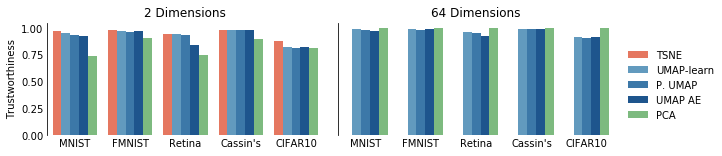

In [89]:
fg = sns.catplot(
    x="dataset",
    y="trustworthiness",
    hue="class_",
    hue_order=["TSNE", "umap-learn", "network", "autoencoder", "PCA"],
    order = ['mnist', 'fmnist', 'macosko2015', 'cassins_dtw', 'cifar10'],
    col="dim",
    height=2.5, 
    aspect=1.75,
    data=metrics_df,
    kind="bar",
    palette=palette,
    #legend=False
)
(fg.despine(bottom=True)
 .set_xticklabels(['MNIST', 'FMNIST', 'Retina', 'Cassin\'s', 'CIFAR10'])
 .set_axis_labels("", "Trustworthiness")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u'both', which=u'both',length=0)
fg._legend._legend_title_box._text.set_text("")
#fg._legend.texts[1].set_text("Param. UMAP")
#fg._legend.texts[2].set_text("UMAP AE")

ax.set_title('2 Dimensions')
ax = fg.axes[0][1]
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_title('64 Dimensions')

fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP-learn')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'network'))[0][0]].set_text('P. UMAP')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'autoencoder'))[0][0]].set_text('UMAP AE')

save_fig(FIGURE_DIR/'trustworthiness_test', save_pdf=True, dpi=300)

In [ ]:
unique_datasets = list(metrics_df.dataset.unique())
unique_dims = list(metrics_df.dim.unique())
unique_metric = ['trustworthiness', 'silhouette_score']
unique_method = list(metrics_df.class_.unique())
unique_datasets, unique_dims, unique_metric, unique_method

In [ ]:
row_idx = [
    np.concatenate([list(np.repeat(i, len(unique_dims))) for i in unique_datasets]),
    np.concatenate([list(unique_dims) for i in unique_datasets]),  
]
row_idx = pd.MultiIndex.from_tuples(list(zip(*row_idx)), names=['dataset', 'dim'])
row_idx

In [ ]:
col_idx = [
    np.concatenate([list(np.repeat(i, len(unique_metric))) for i in unique_method]),
    np.concatenate([list(unique_metric) for i in unique_method]),  

]
col_idx = pd.MultiIndex.from_tuples(list(zip(*col_idx)), names=['method', 'metric'])
col_idx

In [ ]:
results_df = pd.DataFrame(-1*np.ones((len(row_idx), len(col_idx))), index=row_idx, columns=col_idx)
results_df

In [ ]:
results_df = pd.DataFrame(-1*np.ones((len(row_idx), len(col_idx))), index=row_idx, columns=col_idx)
for method_ in unique_method:
    for dataset in unique_datasets:
        for dim in unique_dims:
            sil_scores = metrics_df[(metrics_df.dataset == dataset) &
               (metrics_df.class_ == method_) &
               (metrics_df.dim == dim)
              ]['silhouette_score']
            if len(sil_scores) > 0:
                results_df.loc[(dataset,dim), (method_, 'silhouette_score')] = round(list(sil_scores)[0],3)
                
            trustworthiness_scores = metrics_df[(metrics_df.dataset == dataset) &
               (metrics_df.class_ == method_) &
               (metrics_df.dim == dim)
              ]['trustworthiness']
            if len(trustworthiness_scores) > 0:
                results_df.loc[(dataset,dim), (method_, 'trustworthiness')] = round(list(trustworthiness_scores)[0],3)

In [ ]:
results_df

In [ ]:
unique_datasets = list(metrics_df.dataset.unique())
unique_dims = list(metrics_df.dim.unique())
unique_metric = ['trustworthiness', 'silhouette_score']
unique_method = list(metrics_df.class_.unique())
unique_datasets, unique_dims, unique_metric, unique_method

In [ ]:
row_idx = [
    np.concatenate([list(np.repeat(i, len(unique_method))) for i in unique_dims]),
    np.concatenate([list(unique_method) for i in unique_dims]),  
]
row_idx = pd.MultiIndex.from_tuples(list(zip(*row_idx)), names=['dim', 'method'])
row_idx

In [ ]:
col_idx = [
    np.concatenate([list(np.repeat(i, len(unique_metric))) for i in unique_datasets]),
    np.concatenate([list(unique_metric) for i in unique_datasets]),  

]
col_idx = pd.MultiIndex.from_tuples(list(zip(*col_idx)), names=['dataset', 'metric'])
col_idx

In [ ]:
results_df = pd.DataFrame(-1*np.ones((len(row_idx), len(col_idx))), index=row_idx, columns=col_idx)
for method_ in unique_method:
    for dataset in unique_datasets:
        for dim in unique_dims:
            sil_scores = metrics_df[(metrics_df.dataset == dataset) &
               (metrics_df.class_ == method_) &
               (metrics_df.dim == dim)
              ]['silhouette_score']
            if len(sil_scores) > 0:
                results_df.loc[(dim,method_), (dataset, 'silhouette_score')] = round(list(sil_scores)[0],3)
                
            trustworthiness_scores = metrics_df[(metrics_df.dataset == dataset) &
               (metrics_df.class_ == method_) &
               (metrics_df.dim == dim)
              ]['trustworthiness']
            if len(trustworthiness_scores) > 0:
                results_df.loc[(dim,method_), (dataset, 'trustworthiness')] = round(list(trustworthiness_scores)[0],3)

In [ ]:
results_df

In [ ]:
import seaborn as sns

In [ ]:
results_latex = results_df.to_latex(
    bold_rows=True, multirow=True, multicolumn=True, multicolumn_format="l"
)
replace_list = [
    ["\\begin{tabular}", "\\begin{table}\n\\begin{tabular}"],
    ["\\end{tabular}", "\\end{tabular}\n\\end{table}"],
    ["-1.000", "-"],
    ["-1.00", "-"],
    ["silhouette\_score", "Silhou."],
    ["fmnist", "\\textbf{FMNIST}"],
    ["mnist", "\\textbf{MNIST}"],
    ["macosko2015", "\\textbf{Retina}"],
    ["cassins\_dtw", "\\textbf{Cassin's}"],
    ["trustworthiness", "Trust."],
    ["cifar10", "\\textbf{CIFAR10}"],
    ["dataset", ""],
    ["metric", ""],
    ["dim", ""],
    ["method", ""],
    ["multicolumn{2}{l}", "multicolumn{2}{c}"],
    ["\\\\\n   & \\textbf{TSNE} &           -", "\\\%"],
    ["\\\\\n   & \\textbf{TSNE} &          -", "\\\%"],
    [
        "\textbf{} & \textbf{} &                 &                  &                 &                  &                 &                  &                 &                  &                 &                  \\",
        "",
    ],
    ["\multirow{6}{*}{\textbf{64}}", "\multirow{5}{*}{\textbf{64}}"],
    ["{\\textbf{Cassin's}} \\\\\n", "{\\textbf{Cassin's}} \\\\\n \cmidrule(r){3-4}\cmidrule(r){5-6}\cmidrule(r){7-8}\cmidrule(r){9-10}\cmidrule(r){11-12}"],
    ["\\\\\n\\textbf{} & \\textbf{} &                 &                  &                 &                  &                 &                  &                 &                  &                 &                  ", ""],
    ["\\end{tabular}",
     "\\end{tabular}\n\caption{Silhouette score (Silhou.) and Trustworthiness (Trust.) for five datasets using 2 and 64-dimensional latent projections across each projection method.}\label{metrics}"]
]
for i, j in replace_list:
    results_latex = results_latex.replace(i, j)
print(results_latex)

In [ ]:
results_latex